In [1]:
import os

In [2]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection\\Pretrained Models\\VGG16'

In [3]:
os.chdir("../")
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection'

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [6]:
# Configuration for Kidney Stone Detection with Improved Hyperparameters
BASE_DIR = "artifacts/data_ingestion/Combined_Training_Data"  # Directory containing Stone and Non-Stone folders
MODEL_PATH = "Pretrained Models/VGG16/vgg16_kidney_stone_model.h5"  # Path to the model we just created
SAVE_BEST_MODEL_PATH = "Pretrained Models/VGG16/vgg16_kidney_stone_model_trained.h5"  # Path to save the trained model

# Improved hyperparameters
IMAGE_SIZE = (256, 256)  # Input size for the model (height, width)
BATCH_SIZE = 16  # Smaller batch size for better generalization
INITIAL_LEARNING_RATE = 5e-5  # Lower initial learning rate for fine-tuning
EPOCHS = 50  # More epochs for fine-tuning

# Create a directory to save training plots
PLOTS_DIR = "Pretrained Models/VGG16/training_plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

# Check class balance to determine class weights
stone_dir = os.path.join(BASE_DIR, 'Stone')
non_stone_dir = os.path.join(BASE_DIR, 'Non-Stone')
stone_count = len(os.listdir(stone_dir))
non_stone_count = len(os.listdir(non_stone_dir))
total_count = stone_count + non_stone_count

print(f"Stone images: {stone_count} ({stone_count/total_count:.2%})")
print(f"Non-Stone images: {non_stone_count} ({non_stone_count/total_count:.2%})")

# Calculate class weights to handle imbalance
weight_for_0 = (1 / non_stone_count) * (total_count / 2.0)  # For Non-Stone class
weight_for_1 = (1 / stone_count) * (total_count / 2.0)  # For Stone class

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"Class weights: {class_weight}")

Stone images: 18194 (46.87%)
Non-Stone images: 20627 (53.13%)
Class weights: {0: 0.9410239007126582, 1: 1.066862701989667}


In [7]:
# Enhanced data generators with more aggressive augmentation for kidney stone CT images
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    validation_split=0.2,  # 20% of data for validation
    rotation_range=20,  # Rotate images more
    zoom_range=0.25,  # More zoom variation
    horizontal_flip=True,  # Flip horizontally
    vertical_flip=True,  # Also flip vertically for medical images
    width_shift_range=0.15,  # More horizontal shift
    height_shift_range=0.15,  # More vertical shift
    brightness_range=[0.8, 1.2],  # More brightness variation
    shear_range=0.1,  # Add shear transformation
    channel_shift_range=0.1,  # Slight color variations
    fill_mode='nearest'  # Fill in missing pixels
)

# Print class indices to understand label mapping
train_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification: stone vs non-stone
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

# Print class mapping information
print(f"Class indices: {train_generator.class_indices}")
print(f"Found {train_generator.samples} training samples in {len(train_generator.class_indices)} classes")
print(f"Found {val_generator.samples} validation samples")

Found 31058 images belonging to 2 classes.
Found 7763 images belonging to 2 classes.
Class indices: {'Non-Stone': 0, 'Stone': 1}
Found 31058 training samples in 2 classes
Found 7763 validation samples


In [8]:
# Load the kidney stone detection model
model = load_model(MODEL_PATH)

# Recompile with improved learning rate and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Enhanced callbacks for better training
# 1. Model checkpoint - save the best model
checkpoint_cb = ModelCheckpoint(
    SAVE_BEST_MODEL_PATH, 
    save_best_only=True, 
    monitor='val_auc', 
    mode='max',  # We want to maximize AUC
    verbose=1
)

# 2. Early stopping - prevent overfitting
earlystop_cb = EarlyStopping(
    monitor='val_auc', 
    patience=8,  # More patience for fine-tuning
    restore_best_weights=True, 
    mode='max',  # We want to maximize AUC
    verbose=1
)

# 3. Learning rate reduction on plateau
# This is more reliable than the cosine decay for this application
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half when plateau is detected
    patience=3,  # Wait for 3 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate
    verbose=1  # Print when learning rate is reduced
)

# 4. TensorBoard callback for better visualization
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=f"{PLOTS_DIR}/logs",
    histogram_freq=1,
    write_graph=True,
    update_freq='epoch'
)

# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [9]:
# Train the model with improved parameters for kidney stone detection
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb, tensorboard_cb],
    class_weight=class_weight,  # Use calculated class weights
    workers=2,  # Parallel data loading (reduced to avoid potential issues)
    use_multiprocessing=False,  # Disabled to avoid potential issues
    verbose=1
)


Epoch 1/50
1942/1942 [==============================] - ETA: 0s - loss: 0.5028 - accuracy: 0.7191 - auc: 0.8172 - precision: 0.6995 - recall: 0.7025
Epoch 1: val_auc improved from -inf to 0.93362, saving model to Pretrained Models/VGG16\vgg16_kidney_stone_model_trained.h5
1942/1942 [==============================] - 4513s 2s/step - loss: 0.5028 - accuracy: 0.7191 - auc: 0.8172 - precision: 0.6995 - recall: 0.7025 - val_loss: 0.4264 - val_accuracy: 0.7732 - val_auc: 0.9336 - val_precision: 0.6980 - val_recall: 0.9093 - lr: 5.0000e-05
Epoch 2/50
1942/1942 [==============================] - ETA: 0s - loss: 0.2099 - accuracy: 0.9203 - auc: 0.9708 - precision: 0.9278 - recall: 0.9000
Epoch 2: val_auc improved from 0.93362 to 0.95241, saving model to Pretrained Models/VGG16\vgg16_kidney_stone_model_trained.h5
1942/1942 [==============================] - 6377s 3s/step - loss: 0.2099 - accuracy: 0.9203 - auc: 0.9708 - precision: 0.9278 - recall: 0.9000 - val_loss: 0.4050 - val_accuracy: 0.7817

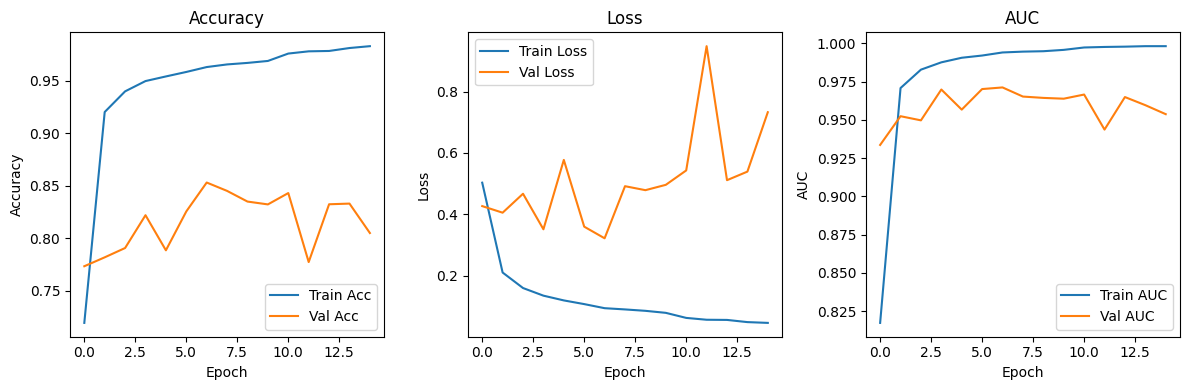

Training completed. Best model saved at: Pretrained Models/VGG16/vgg16_kidney_stone_model_trained.h5
Training plots saved in: Pretrained Models/VGG16/training_plots


In [11]:
# Plot and save training metrics
# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.legend()
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')

plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/training_metrics.png")
plt.show()

# Save the training history for later analysis
import json
with open(f"{PLOTS_DIR}/training_history.json", 'w') as f:
    # Convert numpy values to Python native types for JSON serialization
    history_dict = {k: [float(val) for val in v] for k, v in history.history.items()}
    json.dump(history_dict, f)

print(f"Training completed. Best model saved at: {SAVE_BEST_MODEL_PATH}")
print(f"Training plots saved in: {PLOTS_DIR}")
